Имеются данные взаимодействий с рекламными объявлениями на некоторой площадке за 6 дней (ads_data.csv). И таблица с характеристиками рекламных клиентов (ads_clients_data.csv).

In [227]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
%matplotlib inline

df1 = pd.read_csv("C:/Users/yagjh/Desktop/Python Files/ads_data.csv", parse_dates=["date", "time"])
df2 = pd.read_csv("C:/Users/yagjh/Desktop/Python Files/ads_clients_data.csv", parse_dates=["create_date"])
ads_data = df1.merge(df2, on="client_union_id", how="inner").drop(columns="date_y").rename(columns={"date_x":"placement_date"})
ads_data.head()

,placement_date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,community_id,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,-130129582,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,-130129582,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,-130129582,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,-130129582,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,-130129582,2018-12-04


Посчитайте среднее количество показов и среднее количество кликов на объявления за весь период (округлите до целых).

In [228]:
avg_clickviews = ads_data.groupby(["event", "placement_date"], as_index=False).agg({"platform":"count"}) \
                         .groupby("event", as_index=False).agg({"platform":"mean"}).rename(columns={"platform":"average_count"})
avg_clickviews["average_count"] = avg_clickviews["average_count"].astype(int)
avg_clickviews

,event,average_count
0,click,18196
1,view,148470


Нарисуйте график распределения показов на каждое объявление за весь период.

<AxesSubplot:ylabel='Count'>

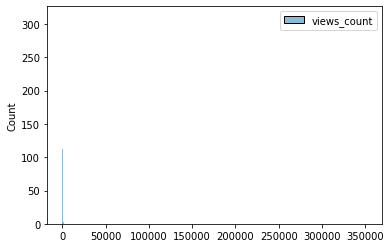

In [229]:
ad_views = ads_data.query("event == 'view'").groupby("ad_id").agg({"event":"count"}).rename(columns={"event":"views_count"})
sns.histplot(data=ad_views)

На графике можно заметить, что большинство значений сконцентрировались около 0. При этом максимальное число показов для объявления ~ 35000. Значит среди объявлений есть такие, для которых число просмотров аномально высоко. Проверим:

In [230]:
ad_views.sort_values("views_count", ascending=False).head(10)

,views_count
ad_id,
112583,351802
107729,184596
107837,51996
28142,24152
45008,19668
39191,17992
116718,11445
38892,9323
22490,8680


Действительно, мы видим довольно высокое число показов лишь для нескольких объявлений. Именно из - за них мастштаб графика не позволяет отобразить как распределилось большинство показов. 
Поэтому отберём для визуализации только 90% всех наблюдений, исключив таким образом наиболее отклоняющиеся.

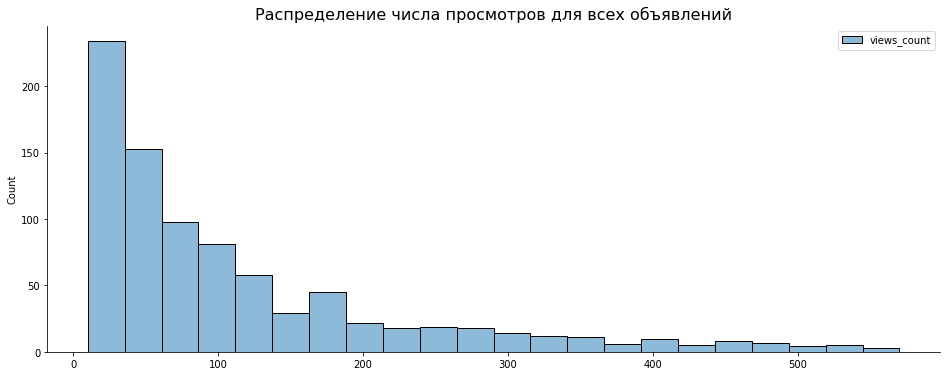

In [231]:
quantile_90 = ad_views.quantile(0.9)[0]
plt.figure(figsize=(16, 6))
plt.title(label="Распределение числа просмотров для всех объявлений", fontsize = 16)
sns.histplot(data=ad_views.query("views_count < @quantile_90"))
sns.despine()

Рассчитайте скользящее среднее показов с окном 2. Какое значение скользящего среднего получим за 6 апреля 2019 года (ответ округлите до целых)?

In [232]:
rolling_views = ads_data.query("event == 'view'").groupby("placement_date").agg({"event":"count"})\
                        .rolling(2).mean().rename(columns={"event":"views_count"})
print(int(rolling_views.at["2019-04-06", "views_count"]), "- значение скользящего среднего за 6 апреля 2019 года")

244176 - значение скользящего среднего за 6 апреля 2019 года


Скользящее среднее часто используется для поиска аномалий в данных. Нанесите на один график значения арифметического среднего по дням и скользящего среднего количества показов. В какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним?


Максимальная разница в 4.005060114488166 показов была 2019-04-06 00:00:00


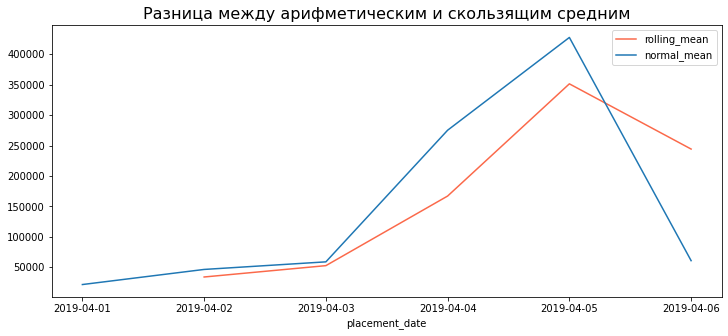

In [233]:
plt.figure(figsize=(12, 5))
plt.title("Разница между арифметическим и скользящим средним", fontsize = 16)
sns.lineplot(data = rolling_views.rename(columns={"views_count":"rolling_mean"}), palette="Reds")
sns.lineplot(data = ads_data.query("event == 'view'").groupby("placement_date").agg({"event":"count"}).rename(columns={"event":"normal_mean"}))
difference_between_mean = abs(rolling_views.rename(columns={"views_count":"rolling_mean"})["rolling_mean"]/
    - ads_data.query("event == 'view'").groupby("placement_date").agg({"event":"count"}).rename(columns={"event":"normal_mean"})["normal_mean"])
print(f"Максимальная разница в {difference_between_mean.max()} показов была {difference_between_mean.idxmax()}")

Напишите функцию, которая найдет проблемное объявление (с наибольшим/наименьшим количеством показов) в день, в который была замечена самая большая по модулю аномалия.

In [234]:
# Краткое описание работы функции:
# Передаём датасет, в котором ищем наиболее резкое изменение числа показов за день и сохраняем этот день в переменную anomaly_day
# Указываем, id тех объявлений, что имеют наибольшее отклонение от среднего.
# Функция учитывает, что в некоторых случаях аномальных объявлений может быть несколько, если у них одинаковое число просмотров.

def find_problem_ad(data):
    difference = abs(data.query("event == 'view'").groupby("placement_date").agg({"event":"count"}).rolling(2).mean()\
                   - data.query("event == 'view'").groupby("placement_date").agg({"event":"count"}))
    anomaly_day = difference.idxmax()[0]
    print("Самый отклоняющийся день -", anomaly_day)
    daily_ads = data.query("event == 'view' & placement_date == @anomaly_day").groupby("ad_id").agg({"event":"count"})
    if int(daily_ads.max() - daily_ads.mean()) > int(daily_ads.mean() - daily_ads.min()):
        print(f"Номера объявлений с аномально высоким числом показов в этот день: {daily_ads[daily_ads.event == daily_ads.max()[0]].index.to_list()}")
    else:
        print(f"Номера объявлений с аномально низким числом показов в этот день: {daily_ads[daily_ads.event == daily_ads.min()[0]].index.to_list()}")
find_problem_ad(ads_data)

Самый отклоняющийся день - 2019-04-06 00:00:00
Номера объявлений с аномально высоким числом показов в этот день: [112583]


Найдите среднее количество дней от даты создания рекламного клиента и первым запуском рекламного объявления этим клиентом.

In [235]:
create_and_publish_diff = ads_data[["client_union_id", "create_date", "placement_date"]].sort_values("placement_date")\
                                                     .drop_duplicates(subset="client_union_id").reset_index(drop=True)
create_and_publish_diff["difference"] = create_and_publish_diff["placement_date"] - create_and_publish_diff["create_date"]
print("Среднее количество дней от даты создания рекламного клиента до запуска первой рекламы:", create_and_publish_diff.difference.mean())
create_and_publish_diff.head()

Среднее количество дней от даты создания рекламного клиента до запуска первой рекламы: 124 days 09:04:43.532219570


,client_union_id,create_date,placement_date,difference
0,34734,2018-12-04,2019-04-01,118 days
1,21532,2018-12-06,2019-04-01,116 days
2,114372,2019-01-31,2019-04-01,60 days
3,34237,2018-10-27,2019-04-01,156 days
4,120081,2019-01-13,2019-04-01,78 days


Вычислите конверсию из создания рекламного клиента в запуск первой рекламы. Ответ дайте в процентах и округлите до сотых.

In [236]:
CR = round(df1["client_union_id"].nunique() / df2["client_union_id"].nunique() * 100, 2)
print(f"Коэффициент конверсии из создания рекламного клиента в запуск первой рекламы = {CR}%")

Коэффициент конверсии из создания рекламного клиента в запуск первой рекламы = 0.69%


Разбейте пользователей на интервалы и определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования. Визуализируйте клиентов по категориям.

Число уникальных клиентов, разместивших объявление по периодам: 
От 3 месяцев до полугода    396
От 1 до 3 месяцев           263
От полугода и более         168
В первый месяц               11 (это ответ)


(Text(0, 0.5, 'Число пользователей'),
 Text(0.5, 1.0, 'Период с регистрации клиента до первого размещения рекламы'))

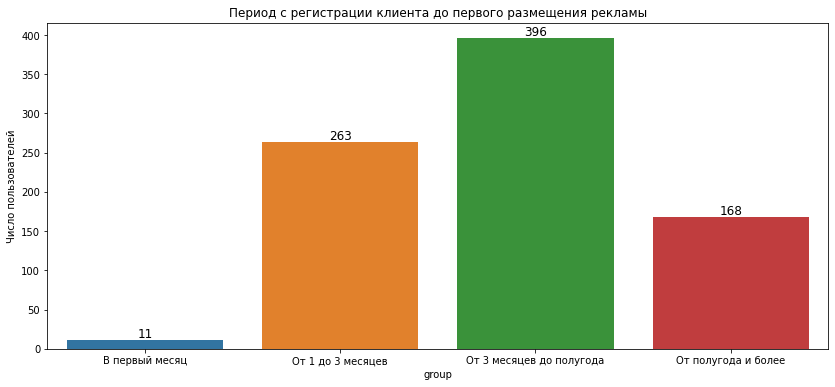

In [237]:
create_and_publish_diff["group"] = pd.cut(create_and_publish_diff["difference"], bins=pd.to_timedelta([0, 30, 90, 180, 365], unit="d"),  
        labels=["В первый месяц", "От 1 до 3 месяцев", "От 3 месяцев до полугода", "От полугода и более"])
print("Число уникальных клиентов, разместивших объявление по периодам: \n" + create_and_publish_diff["group"].value_counts().to_string(), "(это ответ)")

plt.figure(figsize=(14, 6))
plot = sns.barplot(x = create_and_publish_diff.groupby("group", as_index=False).agg({"difference":"count"})["group"],
            y = create_and_publish_diff.groupby("group", as_index=False).agg({"difference":"count"})["difference"])
plot.bar_label(plot.containers[0], size = 12)
plot.set_ylabel("Число пользователей"), plot.set_title("Период с регистрации клиента до первого размещения рекламы")